In [ ]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'

import scipy.sparse as sp
from scipy.sparse.linalg import eigsh
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool


# def create_localiser(L,rho,kappa,disorder):
#     # Function to create the localiser matrix of a 1D Anderson model
#     # Note the open boundary conditions
#     # This also includes the creation of the position operator X

#     # on diagonal disorder
#     diag = (np.random.rand(L)-0.5) * disorder
#     # off diagonal hopping terms
#     off_diag = np.ones(L-1)

#     H = sp.diags([off_diag,diag,off_diag],[-1,0,1],shape=(L,L),format='lil')

#     #H[L-1,0] = 1
#     #H[0,L-1] = 1

#     row_vector = np.linspace(-rho,rho,L)
#     X = sp.diags(row_vector,0,shape=(L,L),format='csr')

#     localiser = sp.bmat([[-H,kappa * X],[kappa * X,H]],format='csr')

#     return localiser


m = 1
S = 2


def create_localiser(L,rho,kappa,disorder):
    mass_term = m * np.ones(L//2)
    shift_term = S * np.ones(L//2 - 1)
    A = sp.diags([mass_term,shift_term],[0,1],shape=(L//2,L//2),format='csr')
    H0 = sp.bmat([[sp.csr_matrix((L//2,L//2)),A.T],[A,sp.csr_matrix((L//2,L//2))]],format='csr')
    disorderA = (np.random.rand(L//2)-0.5) * disorder
    disorderB = (np.random.rand(L//2)-0.5) * disorder
    H_disorderA = sp.diags(disorderA,0,shape=(L//2,L//2),format='csr')
    H_disorderB = sp.diags(disorderB,0,shape=(L//2,L//2),format='csr')
    H = H0 + sp.bmat([[sp.csr_matrix((L//2,L//2)),H_disorderA],[H_disorderB,sp.csr_matrix((L//2,L//2))]],format='csr')

    all_positions = np.linspace(-rho, rho, L)

    positions_A = all_positions[0::2]
    positions_B = all_positions[1::2]

    row_vector_A = sp.diags(positions_A, 0, shape=(L//2, L//2), format='csr')
    row_vector_B = sp.diags(positions_B, 0, shape=(L//2, L//2), format='csr')

    X = sp.bmat([[row_vector_A,sp.csr_matrix((L//2,L//2))],[sp.csr_matrix((L//2,L//2)),row_vector_B]],format='csr')
    localiser = sp.bmat([[kappa * X, H.T],[H,-kappa * X]],format='csr')

    return localiser

def find_eigenvalues(localiser, num_eigenvalues=800):
    # Function to find the positive eigenvalues of the localiser matrix
    # numpy eigsh is best for the sparse case.
    eigvals, eigvecs = eigsh(localiser, k=num_eigenvalues,sigma = 0, which='LM')
    positive_eigvals = eigvals[eigvals > 0]
    #positive_eigvals = eigvals
    return positive_eigvals



# Calculate the adjacent gap ratio r = min(s_i,s_(i+1))/max(s_i,s_(i+1))
def calculate_r(eigvals):
    # Once eigenvalues are found, calculate the r value
    eigvals_s = np.diff(eigvals)
    min_eigvals_s = np.array([min(eigvals_s[i],eigvals_s[i+1]) for i in range(len(eigvals_s)-1)])
    max_eigvals_s = np.array([max(eigvals_s[i],eigvals_s[i+1]) for i in range(len(eigvals_s)-1)])
    r = min_eigvals_s / max_eigvals_s
    return r.mean()


def calculate_z(eigvals):    
    eigvals = sorted(eigvals)
    z = np.zeros(len(eigvals)-4)
    for i in range(2,len(eigvals)-2):
        if abs(eigvals[i+1] - eigvals[i]) < abs(eigvals[i]-eigvals[i-1]):
            nn = abs(eigvals[i+1] - eigvals[i])
            nnn = min(min(abs(eigvals[i]-eigvals[i-1]),abs(eigvals[i+2]-eigvals[i])),abs(eigvals[i-2]-eigvals[i]))
        else:
            nn = abs(eigvals[i]-eigvals[i-1])
            nnn = min(min(abs(eigvals[i+1]-eigvals[i]),abs(eigvals[i-2]-eigvals[i])),abs(eigvals[i+2]-eigvals[i]))
        z[i-2] = nn/nnn
    return z.mean()


def single_iteration(args):
    L, rho, kappa, disorder, i = args
    localiser = create_localiser(L,rho,kappa,disorder)
    positive_eigvals = find_eigenvalues(localiser, L//5)
    r = calculate_r(positive_eigvals)
    z = calculate_z(positive_eigvals)
    print(f"   r value for {i+1}th iteration: {r}")
    print(f"   z value for {i+1}th iteration: {z}")
    return r

L = 1000
rho = 30
kappa = 0.1
disorder = 2

num_iter = 300

m_values = np.linspace(0.1,2,10)
S_values = np.linspace(0.1,2,10)

localiser = create_localiser(L,rho,kappa,disorder)
positive_eigvals = find_eigenvalues(localiser, L//5)

print(calculate_r(positive_eigvals))
print(calculate_z(positive_eigvals))

#plt.hist(positive_eigvals,bins=50)
#plt.title(f"Histogram of SSH Spectral Localiser eigenvalues for L={L}, disorder={disorder}")
#plt.xlabel("E")


results =[[] for _ in m_values]
if __name__ == '__main__':

    with Pool() as pool:
        for j, m in enumerate(m_values):
            print(f"Mass term m: {m}")
            for k, S in enumerate(S_values):
                print(f"Shift term S: {S}")
                args_list = [(L,rho,kappa,disorder,i) for i in range(num_iter)]
                r_values_for_disorder = pool.map(single_iteration,args_list)
                results[j].append((S, m ,np.mean(r_values_for_disorder),np.std(r_values_for_disorder)))
                print(f"Shift: {S}, Mass: {m}, r: {np.mean(r_values_for_disorder)}")
            print(f"System size L: {L}")
            #for disorder in disorder_values:
                #r_values_for_disorder = []
            #    args_list = [(L,rho,kappa,disorder,i) for i in range(num_iter)]
                #for i in range(num_iter):
                #    r = single_iteration(args_list[i])
                #    r_values_for_disorder.append(r)

                #results[j].append((disorder,np.mean(r_values_for_disorder),np.std(r_values_for_disorder)))
            #    r_values_for_disorder = pool.map(single_iteration,args_list)
            #    results[j].append((disorder,np.mean(r_values_for_disorder),np.std(r_values_for_disorder)))
            #    print(f"Disorder: {disorder}, r: {np.mean(r_values_for_disorder)}")

#plot results as heatmap
results = np.array(results)
mean_r_values = results[:,:,2]
std_r_values = results[:,:,3]
plt.imshow(mean_r_values, extent=(min(S_values), max(S_values), min(m_values), max(m_values)), origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Mean r value')
plt.xlabel('Shift term S')
plt.ylabel('Mass term m')
plt.title(f'Mean r value heatmap for L={L}, disorder={disorder}')
plt.show()

0.3152462913092235
0.41542694982113004


In [ ]:
L = 6
rho = 2.5

mass_term = m * np.ones(L//2)
shift_term = S * np.ones(L//2 - 1)
A = sp.diags([shift_term,mass_term],[-1,0],shape=(L//2,L//2),format='csr')
print(A.toarray())
H0 = sp.bmat([[sp.csr_matrix((L//2,L//2)),A],[A.T,sp.csr_matrix((L//2,L//2))]],format='csr')
print(H0.toarray())
disorder = (np.random.rand(L//2)-0.5) * disorder
H_disorder = sp.diags(disorder,0,shape=(L//2,L//2),format='csr')
print(H_disorder.toarray())
H = H0 + sp.bmat([[sp.csr_matrix((L//2,L//2)),H_disorder],[H_disorder,sp.csr_matrix((L//2,L//2))]],format='csr')
print(H.toarray())

#row_vector_A = sp.diags(np.linspace(-rho,(rho-(rho/(2*L))),L//2),0,shape=(L//2,L//2),format='csr')
#row_vector_B = sp.diags(np.linspace(((rho/(2*L) )-rho),rho,L//2),0,shape=(L//2,L//2),format='csr')

all_positions = np.linspace(-rho, rho, L)

positions_A = all_positions[0::2]
positions_B = all_positions[1::2]

row_vector_A = sp.diags(positions_A, 0, shape=(L//2, L//2), format='csr')
row_vector_B = sp.diags(positions_B, 0, shape=(L//2, L//2), format='csr')

X = sp.bmat([[row_vector_A,sp.csr_matrix((L//2,L//2))],[sp.csr_matrix((L//2,L//2)),row_vector_B]],format='csr')
print(X.toarray())
localiser = sp.bmat([[kappa * X, H.T],[H,-kappa * X]],format='csr')

[[1. 0. 0.]
 [2. 1. 0.]
 [0. 2. 1.]]
[[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 2. 1. 0.]
 [0. 0. 0. 0. 2. 1.]
 [1. 2. 0. 0. 0. 0.]
 [0. 1. 2. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]
[[-1.53581280e-04  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  9.67740237e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  5.17221037e-05]]
[[0.         0.         0.         0.99984642 0.         0.        ]
 [0.         0.         0.         2.         1.00009677 0.        ]
 [0.         0.         0.         0.         2.         1.00005172]
 [0.99984642 2.         0.         0.         0.         0.        ]
 [0.         1.00009677 2.         0.         0.         0.        ]
 [0.         0.         1.00005172 0.         0.         0.        ]]
[[-2.5  0.   0.   0.   0.   0. ]
 [ 0.  -0.5  0.   0.   0.   0. ]
 [ 0.   0.   1.5  0.   0.   0. ]
 [ 0.   0.   0.  -1.5  0.   0. ]
 [ 0.   0.   0.   0.   0.5  0. ]
 [ 0.   0.   0.   0.   0.   2.5]]


0.0


Text(0.5, 0, 'Energy')

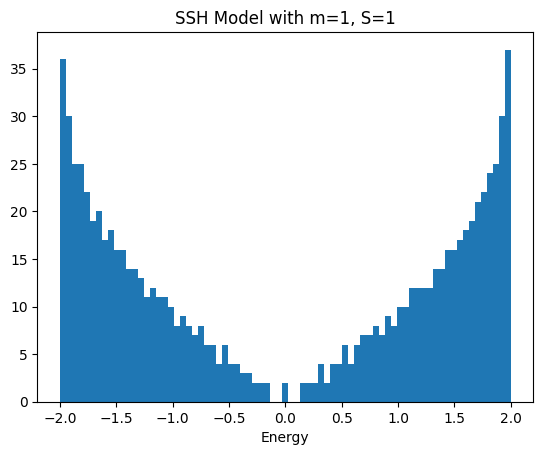

In [59]:
L = 1000
rho = 30
kappa = 0.1
disorder = 0.1


m = 1
S = 1


mass_term = m * np.ones(L//2)
shift_term = S * np.ones(L//2 - 1)
A = sp.diags([mass_term,shift_term],[0,1],shape=(L//2,L//2),format='csr')
H0 = sp.bmat([[sp.csr_matrix((L//2,L//2)),A.T],[A,sp.csr_matrix((L//2,L//2))]],format='csr')
disorderA = (np.random.rand(L//2)-0.5) * disorder
disorderB = (np.random.rand(L//2)-0.5) * disorder
H_disorderA = sp.diags(disorderA,0,shape=(L//2,L//2),format='csr')
H_disorderB = sp.diags(disorderB,0,shape=(L//2,L//2),format='csr')
H = H0 + sp.bmat([[sp.csr_matrix((L//2,L//2)),H_disorderA],[H_disorderB,sp.csr_matrix((L//2,L//2))]],format='csr')

H_dense = H.toarray()

gamma = sp.bmat([[sp.eye(L//2),sp.csr_matrix((L//2,L//2))],[sp.csr_matrix((L//2,L//2)),-sp.eye(L//2)]],format='csr')

gamma_dense = gamma.toarray()
print(sum(sum(H_dense@gamma_dense + gamma_dense@H_dense)))

all_positions = np.linspace(-rho, rho, L)

positions_A = all_positions[0::2]
positions_B = all_positions[1::2]

row_vector_A = sp.diags(positions_A, 0, shape=(L//2, L//2), format='csr')
row_vector_B = sp.diags(positions_B, 0, shape=(L//2, L//2), format='csr')

X = sp.bmat([[row_vector_A,sp.csr_matrix((L//2,L//2))],[sp.csr_matrix((L//2,L//2)),row_vector_B]],format='csr')
localiser = sp.bmat([[kappa * X, H.T],[H,-kappa * X]],format='csr')
localiser_dense = localiser.toarray()


eigvals = np.linalg.eigh(localiser_dense)[0]
plt.hist(eigvals,bins=75, range=(-2,2))

plt.title("SSH Model with m=1, S=1")
plt.xlabel("Energy")

(array([  1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   1.,   1.,   2.,   8., 957.,  15.,   2.,
          0.,   1.,   1.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([-1.25482815e-111, -1.21386259e-111, -1.17289702e-111,
        -1.13193146e-111, -1.09096589e-111, -1.05000033e-111,
        -1.00903476e-111, -9.68069200e-112, -9.27103635e-112,
        -8.86138070e-112, -8.45172505e-112, -8.04206940e-112,
        -7.63241375e-112, -7.22275810e-112, -6.81310245e-112,
        -6.40344680e-112, -5.99379115e-112, -5.58413550e-112,
        -5.17447985e-112, -4.76482421e-112, -4.35516856e-112,
        -3.94551291e-112, -3.53585726e-112, -3.12620161e-112,
        -2.71654596e-112, -2.30689031e-112, -1.89723466e-112,
        -1.48757901e-112, -1.07792336e-112, -6.68267710e-113,
        -2.58612061e-113,  1.51043589e

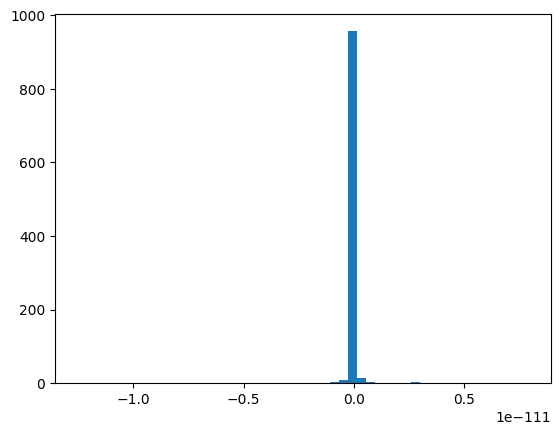

In [25]:
L = 1000
rho = 30
kappa = 0.1
disorder = 0


m = 0.5
S = 1


off_diagonal_vector = np.zeros(L-1)
off_diagonal_vector[0::2] = m
off_diagonal_vector[1::2] = S

H = np.diag(off_diagonal_vector, -1) + np.diag(off_diagonal_vector, 1)

eigvals = find_eigenvalues(H, L-5)
plt.hist(eigvals,bins=50)


0.0
0.0
0


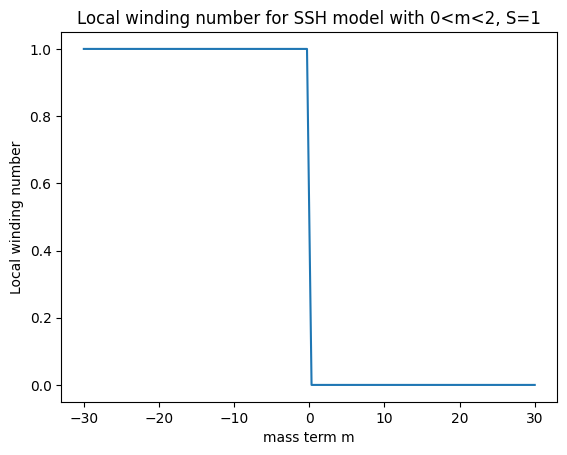

In [24]:
import numpy as np
import scipy.sparse as sp
from scipy.linalg import eigh
L = 100
rho = 30
kappa = 0.1
disorder = 0

m = 1.5
S = 1
mass_term = m * np.ones(L//2)
shift_term = S * np.ones(L//2 - 1)
A = sp.diags([mass_term,shift_term],[0,1],shape=(L//2,L//2),format='csr')
H0 = sp.bmat([[sp.csr_matrix((L//2,L//2)),A.T],[A,sp.csr_matrix((L//2,L//2))]],format='csr')
disorderA = (np.random.rand(L//2)-0.5) * disorder
disorderB = (np.random.rand(L//2)-0.5) * disorder
H_disorderA = sp.diags(disorderA,0,shape=(L//2,L//2),format='csr')
H_disorderB = sp.diags(disorderB,0,shape=(L//2,L//2),format='csr')
H = H0 + sp.bmat([[sp.csr_matrix((L//2,L//2)),H_disorderA],[H_disorderB,sp.csr_matrix((L//2,L//2))]],format='csr')


all_positions = np.linspace(-rho, rho, L)

positions_A = all_positions[0::2]
positions_B = all_positions[1::2]

row_vector_A = sp.diags(positions_A, 0, shape=(L//2, L//2), format='csr')
row_vector_B = sp.diags(positions_B, 0, shape=(L//2, L//2), format='csr')

X = sp.bmat([[row_vector_A,sp.csr_matrix((L//2,L//2))],[sp.csr_matrix((L//2,L//2)),row_vector_B]],format='csr')

gamma = sp.bmat([[-sp.eye(L//2),sp.csr_matrix((L//2,L//2))],[sp.csr_matrix((L//2,L//2)),sp.eye(L//2)]],format='csr')

#testing chiral symmetry
H_dense = H.toarray()
gamma_dense = gamma.toarray()
X_dense = X.toarray()
print(sum(sum(H_dense@gamma_dense + gamma_dense@H_dense)))
print(sum(sum(X_dense@gamma_dense - gamma_dense@X_dense)))

symredlocaliser = ((kappa * X) - (1j * H)) @ gamma

symredlocaliser_dense = symredlocaliser.toarray()

eigvals , eigvecs= eigh(symredlocaliser_dense)

print(len(eigvals[eigvals >= 0])-len(eigvals[eigvals < 0]))


m_vals = np.linspace(0,2,100)

local_winding_number = np.zeros(len(m_vals))
for i, m in enumerate(m_vals):
    mass_term = m * np.ones(L//2)
    shift_term = S * np.ones(L//2 - 1)
    A = sp.diags([mass_term,shift_term],[0,1],shape=(L//2,L//2),format='csr')
    H0 = sp.bmat([[sp.csr_matrix((L//2,L//2)),A.T],[A,sp.csr_matrix((L//2,L//2))]],format='csr')
    disorderA = (np.random.rand(L//2)-0.5) * disorder
    disorderB = (np.random.rand(L//2)-0.5) * disorder
    H_disorderA = sp.diags(disorderA,0,shape=(L//2,L//2),format='csr')
    H_disorderB = sp.diags(disorderB,0,shape=(L//2,L//2),format='csr')
    H = H0 + sp.bmat([[sp.csr_matrix((L//2,L//2)),H_disorderA],[H_disorderB,sp.csr_matrix((L//2,L//2))]],format='csr')
    symredlocaliser = ((kappa * (X)) - (1j * H)) @ gamma
    symredlocaliser_dense = symredlocaliser.toarray()
    eigvals , eigvecs= eigh(symredlocaliser_dense)
    local_winding_number[i] = 0.5*( len(eigvals[eigvals >= 0])-len(eigvals[eigvals < 0]))

import matplotlib.pyplot as plt
plt.plot(all_positions,local_winding_number)
plt.xlabel("mass term m")
plt.ylabel("Local winding number")
plt.title(f"Local winding number for SSH model with 0<m<2, S={S}")
plt.show()





